# Load data

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

MC_DATA_FOLDER = "../results/MC_data_1e7"
Rs = [5.0, 10.0, 15.0]  # cm

# detector ring radius (cm)
R_DET_CM = 15.0

# FWHM computation settings
DMAX_GLOBAL = 7.0        
BIN_WIDTH = 0.05         # cm
NBINS = int(DMAX_GLOBAL / BIN_WIDTH) + 1  # number of bins
EDGES = np.linspace(0.0, DMAX_GLOBAL, NBINS + 1)  # IMPORTANT: nbins+1 edges

# energy thresholds
energy_thresholds = np.array([510, 500, 490, 480, 470, 460, 450, 440, 430, 420, 410, 400], float)

# bootstrap
N_BOOT = 500
BOOT_Q = (0.005, 0.995)  

print("NBINS:", NBINS)
print("BIN_WIDTH:", BIN_WIDTH)
print("EDGES length:", len(EDGES), "(should be NBINS+1)")


NBINS: 141
BIN_WIDTH: 0.05
EDGES length: 142 (should be NBINS+1)


In [2]:
def intersect_cylinder_vec(exit_x, exit_y, exit_z, nx, ny, nz, R_det_cm, eps=1e-12):

    exit_x = np.asarray(exit_x, float)
    exit_y = np.asarray(exit_y, float)
    exit_z = np.asarray(exit_z, float)
    nx = np.asarray(nx, float)
    ny = np.asarray(ny, float)
    nz = np.asarray(nz, float)

    a = nx*nx + ny*ny
    b = 2.0*(exit_x*nx + exit_y*ny)
    c = exit_x*exit_x + exit_y*exit_y - R_det_cm*R_det_cm

    px = np.full_like(exit_x, np.nan, dtype=float)
    py = np.full_like(exit_y, np.nan, dtype=float)
    pz = np.full_like(exit_z, np.nan, dtype=float)

    ok_dir = a > eps
    disc = b*b - 4.0*a*c
    ok = ok_dir & (disc >= 0.0)

    if not np.any(ok):
        return px, py, pz

    sqrt_disc = np.sqrt(disc[ok])
    a_ok = a[ok]
    b_ok = b[ok]

    t1 = (-b_ok - sqrt_disc) / (2.0*a_ok)
    t2 = (-b_ok + sqrt_disc) / (2.0*a_ok)

    t = np.where((t1 > eps) & (t2 > eps), np.minimum(t1, t2),
                 np.where(t1 > eps, t1,
                          np.where(t2 > eps, t2, np.nan)))

    ok_t = ~np.isnan(t)
    idx = np.flatnonzero(ok)[ok_t]
    t_use = t[ok_t]

    px[idx] = exit_x[idx] + t_use * nx[idx]
    py[idx] = exit_y[idx] + t_use * ny[idx]
    pz[idx] = exit_z[idx] + t_use * nz[idx]
    return px, py, pz


In [3]:
def hwhm_from_counts(counts: np.ndarray, edges: np.ndarray):

    counts = np.asarray(counts, float)
    if counts.size < 3:
        return np.nan

    centers = 0.5 * (edges[:-1] + edges[1:])
    i_peak = int(np.argmax(counts))
    cmax = counts[i_peak]
    if cmax <= 0:
        return np.nan

    half = 0.5 * cmax
    post = counts[i_peak:]
    below = np.where(post <= half)[0]
    if below.size == 0:
        return np.nan

    i2 = i_peak + int(below[0])
    if i2 <= 0:
        return np.nan

    x1, y1 = centers[i2-1], counts[i2-1]
    x2, y2 = centers[i2],   counts[i2]

    if y2 == y1:
        return float(x2)
    return float(x1 + (half - y1) * (x2 - x1) / (y2 - y1))


def hwhm_bootstrap_ci_from_counts(
    counts: np.ndarray,
    edges: np.ndarray,
    n_boot: int = 500,
    q_low_high=(0.005, 0.995),
    rng_seed: int = 123,
    min_n: int = 30,
):
    counts = np.asarray(counts, int)
    n = int(counts.sum())
    if n < min_n:
        return np.nan, (np.nan, np.nan)

    p = counts / n
    rng = np.random.default_rng(rng_seed)

    vals = np.empty(int(n_boot), dtype=float)
    for k in range(int(n_boot)):
        boot = rng.multinomial(n, p)
        vals[k] = hwhm_from_counts(boot, edges)

    vals = vals[np.isfinite(vals)]
    if vals.size < max(10, int(0.33 * n_boot)):
        return np.nan, (np.nan, np.nan)

    h_mean = float(np.mean(vals))
    lo, hi = np.quantile(vals, q_low_high)
    return h_mean, (float(lo), float(hi))


In [4]:
def accumulate_from_photon_shard(
    feather_path: str,
    *,
    R_det_cm: float,
    edges: np.ndarray,
    energy_thresholds: np.ndarray,
    hist_extra: np.ndarray,   # shape [nEth, nbins]
):
    # minimal columns
    need = [
        "annihilation_ID", "photon_index",
        "exit_x","exit_y","exit_z",
        "n_x","n_y","n_z",
        "n_object_scatters",
        "E_exit_keV",
    ]
    opt = ["exited", "detected"]

    df = pd.read_feather(feather_path)
    cols = [c for c in need if c in df.columns] + [c for c in opt if c in df.columns]
    df = df[cols]

    # early filters
    if "exited" in df.columns:
        df = df[df["exited"].to_numpy(bool)]
    if "detected" in df.columns:
        df = df[df["detected"].to_numpy(bool)]
    df = df[df["photon_index"].isin([1,2])]
    if len(df) == 0:
        return 0

    # cylinder intersections
    px, py, pz = intersect_cylinder_vec(
        df["exit_x"].to_numpy(float),
        df["exit_y"].to_numpy(float),
        df["exit_z"].to_numpy(float),
        df["n_x"].to_numpy(float),
        df["n_y"].to_numpy(float),
        df["n_z"].to_numpy(float),
        R_det_cm=R_det_cm,
    )
    df["px"], df["py"], df["pz"] = px, py, pz
    df = df.dropna(subset=["px","py","pz"])
    if len(df) == 0:
        return 0

    # sort + keep full pairs only
    df = df.sort_values(["annihilation_ID","photon_index"], kind="mergesort")
    vc = df["annihilation_ID"].value_counts(sort=False)
    good_ids = vc.index[vc.to_numpy() == 2]
    df = df[df["annihilation_ID"].isin(good_ids)]
    if len(df) == 0:
        return 0
    df = df.sort_values(["annihilation_ID","photon_index"], kind="mergesort")

    # reshape into pairs
    P = df[["px","py","pz"]].to_numpy(float).reshape(-1, 2, 3)
    S = df[["n_object_scatters"]].to_numpy(int).reshape(-1, 2)
    E = df[["E_exit_keV"]].to_numpy(float).reshape(-1, 2)

    # compute d for all pairs
    p1 = P[:,0,:]
    p2 = P[:,1,:]
    v = p2 - p1
    vv = np.sum(v*v, axis=1)
    ok = vv > 1e-12
    if not np.any(ok):
        return 0

    p1 = p1[ok]; p2 = p2[ok]; S = S[ok]; E = E[ok]
    v = p2 - p1
    vv = np.sum(v*v, axis=1)
    s = -np.sum(p1*v, axis=1) / vv
    closest = p1 + s[:,None]*v
    d = np.linalg.norm(closest, axis=1)

    m_d = np.isfinite(d) & (d >= 0.0) & (d <= edges[-1])
    if not np.any(m_d):
        return 0
    d = d[m_d]; S = S[m_d]; E = E[m_d]

    baseline = (S[:,0] == 0) & (S[:,1] == 0)
    baseline_count = int(np.sum(baseline))

    extra = (S[:,0] > 0) | (S[:,1] > 0)
    if not np.any(extra):
        return baseline_count

    d_extra = d[extra]
    E_extra = E[extra]
    Emin = np.minimum(E_extra[:,0], E_extra[:,1])

    for j, Eth in enumerate(energy_thresholds):
        mE = Emin >= Eth
        if not np.any(mE):
            continue
        h, _ = np.histogram(d_extra[mE], bins=edges)
        hist_extra[j] += h

    return baseline_count


In [5]:
def compute_fwhm_gain_inputs_for_R(
    R_obj: float,
    *,
    mc_folder: str,
    R_det_cm: float,
    edges: np.ndarray,
    energy_thresholds: np.ndarray,
):
    phot_files = sorted(glob.glob(f"{mc_folder}/photons_*_R{int(R_obj)}.feather"))
    if not phot_files:
        raise FileNotFoundError(f"No photon files found for R={R_obj} in {mc_folder}")

    nbins = len(edges) - 1
    hist_extra = np.zeros((len(energy_thresholds), nbins), dtype=np.int64)

    baseline_total = 0
    for k, f in enumerate(phot_files):
        baseline_total += accumulate_from_photon_shard(
            f,
            R_det_cm=R_det_cm,
            edges=edges,
            energy_thresholds=energy_thresholds,
            hist_extra=hist_extra,
        )
        if (k + 1) % 10 == 0 or (k + 1) == len(phot_files):
            print(f"R={R_obj}: processed {k+1}/{len(phot_files)} shards")

    return baseline_total, hist_extra


In [6]:
tbl_by_R = {}

for R_obj in Rs:
    print(f"\n=== Computing for R={R_obj} cm (fixed ring R_det={R_DET_CM} cm) ===")
    N_unscattered, hist_extra = compute_fwhm_gain_inputs_for_R(
        R_obj,
        mc_folder=MC_DATA_FOLDER,
        R_det_cm=R_DET_CM,
        edges=EDGES,
        energy_thresholds=energy_thresholds,
    )

    rows = []
    for j, Eth in enumerate(energy_thresholds):
        counts = hist_extra[j]
        N_extra = int(counts.sum())
        gain_pct = (N_extra / N_unscattered * 100.0) if N_unscattered > 0 else np.nan

        H, (H_lo, H_hi) = hwhm_bootstrap_ci_from_counts(
            counts, EDGES, n_boot=N_BOOT, q_low_high=BOOT_Q, rng_seed=123
        )
        FWHM = 2.0 * H
        F_lo, F_hi = 2.0 * H_lo, 2.0 * H_hi

        rows.append({
            "Eth_keV": float(Eth),
            "N_extra": int(N_extra),
            "N_unscattered": int(N_unscattered),
            "Gain_%": float(gain_pct),
            "FWHM_cm": float(FWHM),
            "FWHM_lo_cm": float(F_lo),
            "FWHM_hi_cm": float(F_hi),
        })

    tbl = pd.DataFrame(rows).sort_values("Eth_keV", ascending=False).reset_index(drop=True)
    tbl_by_R[R_obj] = tbl

for R_obj in Rs:
    tbl = tbl_by_R[R_obj]
    print(f"\n--- R={R_obj:.0f} cm ---")
    print(tbl[["Eth_keV", "N_extra", "Gain_%", "FWHM_cm", "FWHM_lo_cm", "FWHM_hi_cm"]].to_string(index=False))



=== Computing for R=5.0 cm (fixed ring R_det=15.0 cm) ===
R=5.0: processed 10/50 shards
R=5.0: processed 20/50 shards
R=5.0: processed 30/50 shards
R=5.0: processed 40/50 shards
R=5.0: processed 50/50 shards

=== Computing for R=10.0 cm (fixed ring R_det=15.0 cm) ===
R=10.0: processed 10/50 shards
R=10.0: processed 20/50 shards
R=10.0: processed 30/50 shards
R=10.0: processed 40/50 shards
R=10.0: processed 50/50 shards

=== Computing for R=15.0 cm (fixed ring R_det=15.0 cm) ===
R=15.0: processed 10/50 shards
R=15.0: processed 20/50 shards
R=15.0: processed 30/50 shards
R=15.0: processed 40/50 shards
R=15.0: processed 50/50 shards

--- R=5 cm ---
 Eth_keV  N_extra    Gain_%  FWHM_cm  FWHM_lo_cm  FWHM_hi_cm
   510.0    17989  0.630579 0.184237    0.176123    0.190429
   500.0   129261  4.531065 0.525015    0.510050    0.544340
   490.0   241451  8.463730 0.769673    0.746305    0.791246
   480.0   353397 12.387842 0.966926    0.943257    0.983209
   470.0   464274 16.274481 1.126517    

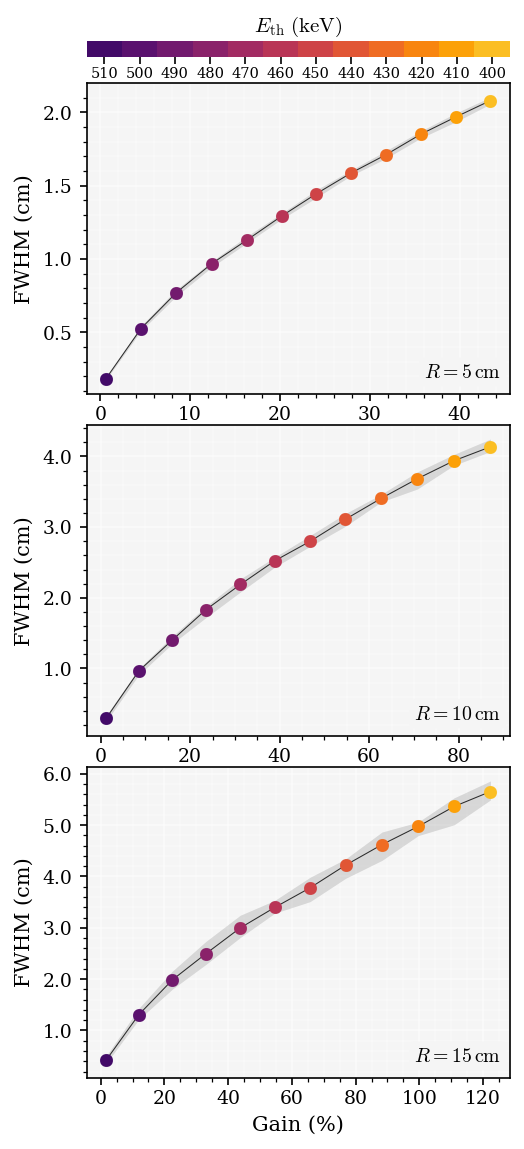

In [7]:
import numpy as np
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.pyplot as plt

CMAP = plt.cm.inferno
CMAP_MIN, CMAP_MAX = 0.20, 0.85
eth_colors = CMAP(np.linspace(CMAP_MIN, CMAP_MAX, len(energy_thresholds)))
eth_to_idx = {float(E): j for j, E in enumerate(energy_thresholds)}

COLUMNWIDTH_PT = 242.5389
INCH_PER_PT = 1 / 72.27
FIG_W = COLUMNWIDTH_PT * INCH_PER_PT
FIG_H = FIG_W * 2.6

mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.grid": True,
    "axes.axisbelow": True,
    "grid.alpha": 0.5,
    "grid.color": "white",
    "axes.facecolor": "whitesmoke",
})

fig, axes = plt.subplots(3, 1, figsize=(FIG_W, FIG_H), sharex=False)
fig.subplots_adjust(left=0.14, right=0.98, bottom=0.1, top=0.86, hspace=0.1)

GAIN_LABEL_Y = -0.12

for i, R_obj in enumerate(Rs):
    ax = axes[i]
    tbl = tbl_by_R[R_obj]

    x = tbl["Gain_%"].to_numpy(float)
    y = tbl["FWHM_cm"].to_numpy(float)
    lo = tbl["FWHM_lo_cm"].to_numpy(float)
    hi = tbl["FWHM_hi_cm"].to_numpy(float)
    eths = tbl["Eth_keV"].to_numpy(float)

    order = np.argsort(x)
    x2, y2, lo2, hi2, eths2 = x[order], y[order], lo[order], hi[order], eths[order]

    ok = np.isfinite(x2) & np.isfinite(y2) & np.isfinite(lo2) & np.isfinite(hi2)
    x2, y2, lo2, hi2, eths2 = x2[ok], y2[ok], lo2[ok], hi2[ok], eths2[ok]
    if x2.size == 0:
        ax.text(0.5, 0.5, "No finite data", transform=ax.transAxes, ha="center", va="center")
        continue

    ax.fill_between(x2, lo2, hi2, color="black", alpha=0.12, linewidth=0, zorder=1)
    ax.plot(x2, y2, "-", color="black", linewidth=0.5, zorder=2, alpha=0.8)

    for xx, yy, Eth in zip(x2, y2, eths2):
        j = eth_to_idx.get(float(Eth), None)
        col = eth_colors[j] if j is not None else "black"
        ax.scatter(xx, yy, s=38, color=col, edgecolor=None, linewidth=0.1, zorder=7)

    ax.set_ylabel("FWHM (cm)")
    ax.minorticks_on()
    ax.grid(True, which="major")
    ax.grid(True, which="minor", alpha=0.30, linewidth=0.9)

    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter("%.0f"))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.1f"))
    ax.tick_params(axis="x", which="major", pad=2)

    if i == 2:
        ax.text(
            0.5, GAIN_LABEL_Y, "Gain (%)",
            transform=ax.transAxes,
            ha="center", va="top",
            fontsize=10,
            clip_on=False,
        )

    ax.text(
        0.98, 0.04,
        rf"$R={R_obj:.0f}\,\mathrm{{cm}}$",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=9.5,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="whitesmoke", edgecolor="none", alpha=0.85),
    )

# colorbar
N = len(energy_thresholds)
bounds = np.arange(N + 1)
norm = mpl.colors.BoundaryNorm(bounds, ncolors=N)
sm = mpl.cm.ScalarMappable(cmap=mpl.colors.ListedColormap(eth_colors), norm=norm)
sm.set_array([])

top_pos = axes[0].get_position()
cbar_h = 0.012
gap = 0.020
cax = fig.add_axes([top_pos.x0, top_pos.y1 + gap, top_pos.width, cbar_h])

cbar = fig.colorbar(
    sm, cax=cax, orientation="horizontal",
    ticks=np.arange(N) + 0.5, drawedges=False,
)
cbar.ax.set_xticklabels([f"{Eth:.0f}" for Eth in energy_thresholds])
cbar.set_label(r"$E_{\mathrm{th}}~\mathrm{(keV)}$", fontsize=10, labelpad=4.5)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.tick_params(axis="x", labelsize=7, pad=1)
cbar.outline.set_visible(False)
cbar.ax.tick_params(which="minor", bottom=False, top=False)

plt.show()

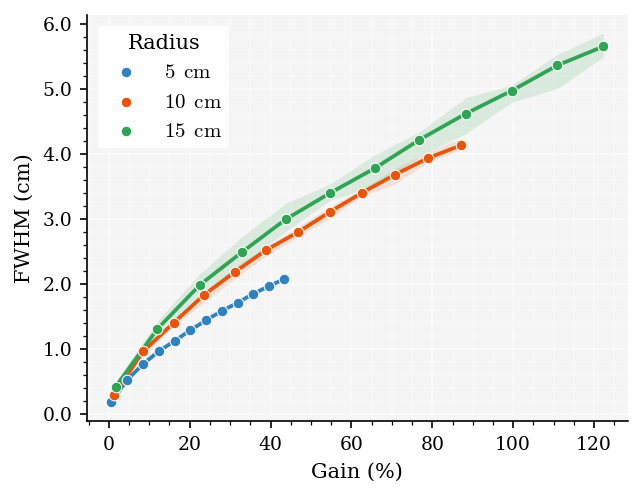

In [9]:
line_colors = {
    5:  "#3182bd",   # darker blue
    10: "#e6550d",   # darker orange
    15: "#31a354",   # darker green
}

fig2, ax2 = plt.subplots(figsize=(FIG_W*1.25, FIG_W*0.95))
fig2.subplots_adjust(left=0.12, right=0.98, bottom=0.12, top=0.97)

for R in sorted(tbl_by_R.keys(), key=float):
    tbl = tbl_by_R[R]
    col = line_colors.get(int(round(float(R))), "black")

    x   = tbl["Gain_%"].to_numpy(float)
    y   = tbl["FWHM_cm"].to_numpy(float)
    lo  = tbl["FWHM_lo_cm"].to_numpy(float)
    hi  = tbl["FWHM_hi_cm"].to_numpy(float)
    
    order = np.argsort(x)
    x2, y2, lo2, hi2 = x[order], y[order], lo[order], hi[order]
    ax2.fill_between(
        x2, lo2, hi2,
        color=col, alpha=0.14, linewidth=0, zorder=1
    )

    ax2.plot(
        x2, y2,
        "-", color=col, linewidth=1.8, zorder=2
    )

    ax2.scatter(
        x2, y2,
        s=26, color=col, edgecolor="white", linewidth=0.5,
        zorder=3, label=rf"${int(round(float(R)))}\,~\mathrm{{cm}}$"
    )


ax2.set_xlabel("Gain (%)")
ax2.set_ylabel("FWHM (cm)")

ax2.xaxis.set_major_formatter(mticker.FormatStrFormatter("%.0f"))
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.1f"))

ax2.minorticks_on()
ax2.grid(True, which="major")
ax2.grid(True, which="minor", alpha=0.25, linewidth=0.8)

leg = ax2.legend(
    title="Radius",
    loc="upper left",
    frameon=True,
)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_edgecolor("whitesmoke")
leg.get_frame().set_alpha(0.95)

for sp in ("top", "right"):
    ax2.spines[sp].set_visible(False)




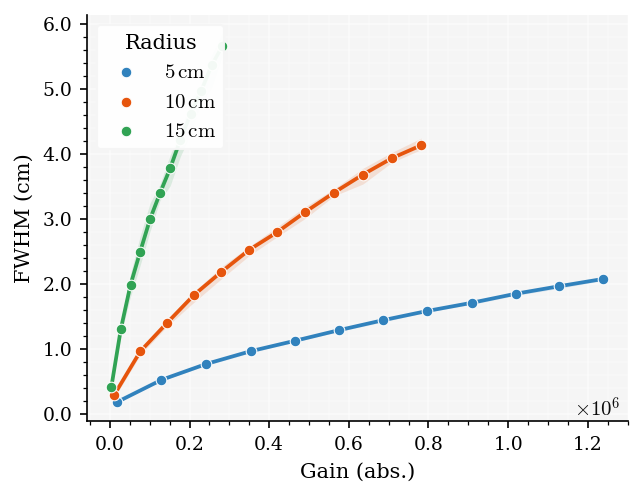

In [10]:
import numpy as np
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.pyplot as plt

line_colors = {
    5:  "#3182bd",   # darker blue
    10: "#e6550d",   # darker orange
    15: "#31a354",   # darker green
}

fig2, ax2 = plt.subplots(figsize=(FIG_W*1.25, FIG_W*0.95))
fig2.subplots_adjust(left=0.12, right=0.98, bottom=0.12, top=0.97)

for R in sorted(tbl_by_R.keys(), key=float):
    tbl = tbl_by_R[R]
    col = line_colors.get(int(round(float(R))), "black")

    x   = tbl["N_extra"].to_numpy(float)         # ABSOLUTE gain
    y   = tbl["FWHM_cm"].to_numpy(float)
    lo  = tbl["FWHM_lo_cm"].to_numpy(float)
    hi  = tbl["FWHM_hi_cm"].to_numpy(float)

    order = np.argsort(x)
    x2, y2, lo2, hi2 = x[order], y[order], lo[order], hi[order]

    ax2.fill_between(x2, lo2, hi2, color=col, alpha=0.14, linewidth=0, zorder=1)
    ax2.plot(x2, y2, "-", color=col, linewidth=1.8, zorder=2)

    ax2.scatter(
        x2, y2,
        s=26, color=col, edgecolor="white", linewidth=0.5,
        zorder=3, label=rf"${int(round(float(R)))}\,\mathrm{{cm}}$"
    )

# Labels
ax2.set_xlabel("Gain (abs.)")   # absolute gain
ax2.set_ylabel("FWHM (cm)")
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.1f"))


# scientific notation with ×10^x on x-axis to the right
sf = mticker.ScalarFormatter(useMathText=True)
sf.set_scientific(True)
sf.set_powerlimits((0, 0))
ax2.xaxis.set_major_formatter(sf)

# force formatter to decide exponent
fig2.canvas.draw()

oom = ax2.xaxis.get_major_formatter().orderOfMagnitude
ax2.xaxis.offsetText.set_visible(False)   # hide Matplotlib offset text

scale = (10.0 ** oom) if oom != 0 else 1.0

# replace tick labels by scaled decimals
ax2.xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda v, pos, s=scale: f"{(v/s):.1f}")
)

# draw ×10^oom 
if oom != 0:
    ax2.text(
        0.9, +0.06, rf"$\times 10^{{{oom}}}$",
        transform=ax2.transAxes,
        ha="left", va="top",
        fontsize=10,
        clip_on=False,
        alpha=0.95,
    )

# Styling
ax2.minorticks_on()
ax2.grid(True, which="major")
ax2.grid(True, which="minor", alpha=0.25, linewidth=0.8)

leg = ax2.legend(title="Radius", loc="upper left", frameon=True)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_edgecolor("whitesmoke")
leg.get_frame().set_alpha(0.95)

for sp in ("top", "right"):
    ax2.spines[sp].set_visible(False)



